# 05a4 – E3SFCA Capacity Scenario Runner

This notebook applies the Enhanced 3-Step Floating Catchment Area (E3SFCA) method to evaluate CT access under baseline and expansion scenarios.

---

### Purpose

We compare population-level CT scanner accessibility under four capacity scenarios:

- **Baseline** (existing Acute + CDC sites)
- **+5% capacity** (4 new sites, 1 scanner each)
- **+10% capacity** (6 new sites, 2×2, 4×1 scanners)
- **+20% capacity** (8 new sites, 2 scanners each)

---

### Input Files

- LSOA population + demand (`gdf_lsoa_CT_accessibility_2024.gpkg`)
- LSOA-to-LSOA travel matrix (`LSOA_to_LSOA_complete.csv`)
- Site capacity files (baseline + uplift scenarios in `E3SFCA_Scenarios/`)
- NHS CT capability reference files (Acute, CDC)

---

### Outputs

- Accessibility scores (`Fi`) for each LSOA per scenario
- Supply-to-demand (`Rj`) for each site
- Visual 2×2 maps comparing scenario impacts
- Scenario outputs exported to GPKG and CSV


In [11]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import mapclassify
import warnings

warnings.filterwarnings("ignore")


In [37]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------
import os

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
lsoa_gpkg_path   = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")

# Prefer densified OD; fall back to raw if not present
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete_densified.csv")
if not os.path.exists(travel_matrix_path):
    print("⚠️  Densified OD not found; using raw OD instead.")
    travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
print(f"Using travel matrix: {os.path.basename(travel_matrix_path)}")

# Reference site files (used for validation, not scenario runs)
cdc_path   = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Scenario CT capacity files (with baseline sites already included)
scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")
scenario_files = {
    "Baseline": os.path.join(scenario_dir, "baseline_ct_sites.csv"),
    "+5%":      os.path.join(scenario_dir, "scenario_5pct_plus_baseline.csv"),
    "+10%":     os.path.join(scenario_dir, "scenario_10pct_plus_baseline.csv"),
    "+20%":     os.path.join(scenario_dir, "scenario_20pct_plus_baseline.csv"),
}

# Output directory
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# --- tiny sanity pings (optional, cheap) ---
for p in [lsoa_access_path, lsoa_gpkg_path, travel_matrix_path]:
    if not os.path.exists(p):
        print(f"Missing file: {p}")
for label, p in scenario_files.items():
    if not os.path.exists(p):
        print(f"Scenario file not found ({label}): {p}")


Using travel matrix: LSOA_to_LSOA_complete_densified.csv


In [38]:
# ----------------------------------------------------------
# Step 2 – Load Travel Matrix and LSOA Base Data
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np

# --- Load the full LSOA-to-LSOA travel matrix (robust to header variants) ---
df_travel = pd.read_csv(travel_matrix_path)

# Normalise expected column names
rename_map = {}
if "origin_lsoa" in df_travel.columns:        rename_map["origin_lsoa"] = "origin_name"
if "dest_lsoa" in df_travel.columns:          rename_map["dest_lsoa"] = "destination_name"
if "car_travel_minutes" in df_travel.columns: rename_map["car_travel_minutes"] = "travel_time_car"
df_travel = df_travel.rename(columns=rename_map)

required_cols = {"origin_name", "destination_name", "travel_time_car"}
missing = required_cols - set(df_travel.columns)
if missing:
    raise KeyError(f"Travel matrix missing columns: {missing}")

# Clean/standardise types
for c in ["origin_name", "destination_name"]:
    df_travel[c] = df_travel[c].astype(str).str.strip()
df_travel["travel_time_car"] = pd.to_numeric(df_travel["travel_time_car"], errors="coerce")

# Quick OD diagnostics (helps catch accidental ≤60 pre-filters or NaNs)
o_set = set(df_travel["origin_name"].unique())
d_set = set(df_travel["destination_name"].unique())
has_diag = (df_travel["origin_name"] == df_travel["destination_name"]).any()
diag_zero_share = (
    df_travel.loc[df_travel["origin_name"] == df_travel["destination_name"], "travel_time_car"]
    .eq(0).mean() if has_diag else np.nan
)
print("— OD QUICK CHECK —")
print(f"Unique origins: {len(o_set)} | destinations: {len(d_set)} | identical sets: {o_set == d_set}")
print(f"Rows: {len(df_travel):,} | has diagonal: {has_diag} | origin==dest zero share: {diag_zero_share:.3f}")
print(f"NaN times: {df_travel['travel_time_car'].isna().sum():,}")

# --- ≤60 view (used in E3SFCA calculations/plots) ---
df_travel_car = df_travel[df_travel["travel_time_car"] <= 60].copy()
print(f"Travel matrix (≤60 min): {df_travel_car.shape} | share ≤60: {len(df_travel_car)/max(1,len(df_travel)):.3f}")

# --- Load base LSOA GeoDataFrame with demand + geometry ---
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)
assert {"lsoa21cd", "ct_total_demand", "geometry"} <= set(gdf_lsoa.columns), \
       "Expected columns missing from LSOA GPKG."
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()
print("LSOA base shape:", gdf_lsoa.shape)

# Clean IDs in the ≤60 view (already normalised above; keep consistent)
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()
df_travel_car["destination_name"] = df_travel_car["destination_name"].astype(str).str.strip()


— OD QUICK CHECK —
Unique origins: 3451 | destinations: 3451 | identical sets: True
Rows: 11,909,401 | has diagonal: True | origin==dest zero share: 1.000
NaN times: 0
Travel matrix (≤60 min): (2409234, 3) | share ≤60: 0.202
LSOA base shape: (3451, 51)


In [39]:
# ----------------------------------------------------------
# Step 3 – Load All Scenario Site Files
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd

scenario_dir = os.path.join(processed_dir, "E3SFCA_Scenarios")

scenario_files = {
    "Baseline": "baseline_ct_sites.csv",
    "+5%":      "scenario_5pct_plus_baseline.csv",
    "+10%":     "scenario_10pct_plus_baseline.csv",
    "+20%":     "scenario_20pct_plus_baseline.csv",
}

scenario_site_data = {}

for label, fname in scenario_files.items():
    path = os.path.join(scenario_dir, fname)
    if not os.path.exists(path):
        print(f"⚠️  Missing scenario file for {label}: {path}")
        continue

    df_sites = pd.read_csv(path)

    # Normalise/expect columns
    rename_map = {}
    if "lsoa" in df_sites.columns and "lsoa21cd" not in df_sites.columns:
        rename_map["lsoa"] = "lsoa21cd"
    if "site_name" in df_sites.columns and "Site Name" not in df_sites.columns:
        rename_map["site_name"] = "Site Name"
    if "scanners" in df_sites.columns and "scanner_count" not in df_sites.columns:
        rename_map["scanners"] = "scanner_count"
    df_sites = df_sites.rename(columns=rename_map)

    required = {"Site Name", "lsoa21cd", "scanner_count"}
    missing = required - set(df_sites.columns)
    if missing:
        raise KeyError(f"{label}: required columns missing: {missing}")

    # Clean types/IDs
    df_sites = df_sites[df_sites["lsoa21cd"].notna()].copy()
    df_sites["lsoa21cd"] = df_sites["lsoa21cd"].astype(str).str.strip()
    df_sites["Site Name"] = df_sites["Site Name"].astype(str).str.strip()

    # Scanner count numeric (coerce), drop negatives
    df_sites["scanner_count"] = pd.to_numeric(df_sites["scanner_count"], errors="coerce")
    neg = (df_sites["scanner_count"] < 0).sum()
    if neg:
        print(f"⚠️  {label}: dropping {neg} rows with negative scanner_count")
        df_sites = df_sites[df_sites["scanner_count"] >= 0]
    df_sites["scanner_count"] = df_sites["scanner_count"].fillna(0)

    # De-duplicate per scenario by LSOA (keep first)
    before = len(df_sites)
    df_sites = df_sites.drop_duplicates(subset=["lsoa21cd"], keep="first")
    dupes_removed = before - len(df_sites)

    # Store
    scenario_site_data[label] = df_sites

    # Report
    print(f"{label:>8} – Loaded {len(df_sites):3} rows | unique LSOAs={df_sites['lsoa21cd'].nunique():3} "
          f"| dupes_removed={dupes_removed:2} | total_scanners={df_sites['scanner_count'].sum():.0f}")

# Build a baseline LSOA set for later plotting/exclusions
baseline_lsoa = set()
if "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"])

# (Optional) also include CDC/Acute LSOAs if those layers are loaded
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# Sanity: ensure site LSOAs exist in the LSOA layer (geometry join will work)
if isinstance(gdf_lsoa, gpd.GeoDataFrame) and not gdf_lsoa.empty:
    lsoa_all = set(gdf_lsoa["lsoa21cd"].astype(str))
    for label, df in scenario_site_data.items():
        missing_in_geom = sorted(set(df["lsoa21cd"]) - lsoa_all)
        if missing_in_geom:
            print(f"⚠️  {label}: {len(missing_in_geom)} site LSOAs not found in gdf_lsoa (sample): {missing_in_geom[:5]}")


Baseline – Loaded  34 rows | unique LSOAs= 34 | dupes_removed= 2 | total_scanners=74
     +5% – Loaded  37 rows | unique LSOAs= 37 | dupes_removed= 3 | total_scanners=77
    +10% – Loaded  40 rows | unique LSOAs= 40 | dupes_removed= 2 | total_scanners=82
    +20% – Loaded  42 rows | unique LSOAs= 42 | dupes_removed= 2 | total_scanners=90


In [40]:
# ----------------------------------------------------------
# Step 4 – Filter Travel Matrix to Scenario-Specific CT Sites
# ----------------------------------------------------------

import numpy as np
import pandas as pd

# Ensure ID columns are strings (belt & braces)
df_travel_car["destination_name"] = df_travel_car["destination_name"].astype(str).str.strip()
df_travel_car["origin_name"] = df_travel_car["origin_name"].astype(str).str.strip()

# Pre-compute sets for fast membership tests
all_dest_le60 = set(df_travel_car["destination_name"].unique())
all_orig_le60 = set(df_travel_car["origin_name"].unique())
all_lsoa_ids  = set(gdf_lsoa["lsoa21cd"].astype(str).str.strip().unique())

travel_matrices_by_scenario = {}

for label, df_sites in scenario_site_data.items():
    print(f"\nFiltering travel matrix for: {label}")

    # Requested destination LSOAs (deduped, string)
    ct_lsoa_codes = pd.Index(df_sites["lsoa21cd"].astype(str).str.strip()).unique()
    n_req = len(ct_lsoa_codes)

    # Which of those exist in the ≤60 matrix?
    matched = ct_lsoa_codes.intersection(all_dest_le60)
    missing = ct_lsoa_codes.difference(all_dest_le60)

    # Filter ≤60 min matrix to matched destinations only
    df_filtered = df_travel_car[df_travel_car["destination_name"].isin(matched)].copy()

    # Coverage by destination (how many origins ≤60 for each site)
    per_dest_counts = df_filtered.groupby("destination_name")["origin_name"].nunique()
    zero_rows_sites = list(missing)  # explicitly not present in ≤60
    fewest = per_dest_counts.sort_values().head(5)

    # Origins represented
    origins_present = set(df_filtered["origin_name"].unique())
    origins_missing = all_lsoa_ids - origins_present

    # Prints
    print(f"{label} – sites requested: {n_req} | matched in ≤60: {len(matched)} | missing: {len(missing)}")
    print(f"{label} – filtered rows: {len(df_filtered):,} | avg rows/site: "
          f"{(len(df_filtered)/max(len(matched),1)):.1f}")
    if len(missing) > 0:
        print(f"  ⚠ Sites with NO origins ≤60 min (excluded from matrix): {len(missing)}"
              f" | sample: {sorted(list(missing))[:5]}")
    if not per_dest_counts.empty:
        print("  Destinations per site (≤60) – min block:")
        print(fewest.to_string())
    print(f"  Origins missing from ≤60 view: {len(origins_missing)}")

    # Save for next step
    travel_matrices_by_scenario[label] = df_filtered



Filtering travel matrix for: Baseline
Baseline – sites requested: 34 | matched in ≤60: 34 | missing: 0
Baseline – filtered rows: 23,573 | avg rows/site: 693.3
  Destinations per site (≤60) – min block:
destination_name
E01020134    128
E01018995    177
E01018865    243
E01020556    386
E01015217    406
  Origins missing from ≤60 view: 0

Filtering travel matrix for: +5%
+5% – sites requested: 37 | matched in ≤60: 37 | missing: 0
+5% – filtered rows: 26,017 | avg rows/site: 703.2
  Destinations per site (≤60) – min block:
destination_name
E01020134    128
E01018995    177
E01018865    243
E01020556    386
E01020061    404
  Origins missing from ≤60 view: 0

Filtering travel matrix for: +10%
+10% – sites requested: 40 | matched in ≤60: 40 | missing: 0
+10% – filtered rows: 27,337 | avg rows/site: 683.4
  Destinations per site (≤60) – min block:
destination_name
E01020134    128
E01018995    177
E01018865    243
E01020556    386
E01019052    389
  Origins missing from ≤60 view: 0

Filter

In [41]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay to Each Scenario
# ----------------------------------------------------------

import numpy as np
import pandas as pd

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nApplying decay weights for: {label}")

    # Work on a copy; ensure numeric times
    df = df_travel_scenario.copy()
    df["travel_time_car"] = pd.to_numeric(df["travel_time_car"], errors="coerce")

    # Drop NaNs in travel_time_car (shouldn't exist if ≤60 filter was clean)
    n_nan = df["travel_time_car"].isna().sum()
    if n_nan:
        print(f"  ⚠ Dropping {n_nan} rows with NaN travel_time_car")
        df = df[df["travel_time_car"].notna()].copy()

    # Quick sanity on range
    t = df["travel_time_car"].to_numpy()
    share_gt60 = (t > 60).mean()
    if share_gt60 > 0:
        print(f"  ⚠ {share_gt60:.2%} of rows have >60 min — assigning 0.01 by rule")

    # Vectorised stepwise decay (0–60 mins, else 0.01)
    tt = df["travel_time_car"]
    conds = [
        (tt <= 10),
        (tt > 10) & (tt <= 20),
        (tt > 20) & (tt <= 30),
        (tt > 30) & (tt <= 40),
        (tt > 40) & (tt <= 50),
        (tt > 50) & (tt <= 60),
        (tt > 60)
    ]
    choices = [1.0, 0.75, 0.5, 0.3, 0.15, 0.05, 0.01]
    df["decay_weight"] = np.select(conds, choices, default=0.01).astype(float)

    # Save back
    travel_matrices_by_scenario[label] = df

    # Summary
    vc = df["decay_weight"].value_counts().sort_index()
    print("  Decay weight distribution:")
    print(vc.to_string())



Applying decay weights for: Baseline
  Decay weight distribution:
decay_weight
0.05    7860
0.15    5656
0.30    3469
0.50    2925
0.75    2483
1.00    1180

Applying decay weights for: +5%
  Decay weight distribution:
decay_weight
0.05    8760
0.15    6423
0.30    3826
0.50    3202
0.75    2579
1.00    1227

Applying decay weights for: +10%
  Decay weight distribution:
decay_weight
0.05    9405
0.15    6400
0.30    4006
0.50    3465
0.75    2755
1.00    1306

Applying decay weights for: +20%
  Decay weight distribution:
decay_weight
0.05    9456
0.15    6815
0.30    4389
0.50    3693
0.75    2822
1.00    1293


In [42]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios (Rj) per Scenario
# ----------------------------------------------------------

import numpy as np
import pandas as pd

rj_lookup_by_scenario = {}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nCalculating Rj for: {label}")

    # --- Site supply (aggregate by LSOA just in case) ---
    df_sites = scenario_site_data[label].copy()
    df_sites["lsoa21cd"]    = df_sites["lsoa21cd"].astype(str).str.strip()
    df_sites["scanner_count"] = pd.to_numeric(df_sites["scanner_count"], errors="coerce").fillna(0.0)
    supply_df = (
        df_sites.groupby("lsoa21cd", as_index=False)["scanner_count"]
                .sum()
                .rename(columns={"lsoa21cd": "destination_name"})
    )

    # --- Travel matrix + demand join ---
    df = df_travel_scenario.copy()
    df["origin_name"]      = df["origin_name"].astype(str).str.strip()
    df["destination_name"] = df["destination_name"].astype(str).str.strip()
    df["decay_weight"]     = pd.to_numeric(df["decay_weight"], errors="coerce").fillna(0.0)

    demand = gdf_lsoa[["lsoa21cd", "ct_total_demand"]].copy()
    demand["lsoa21cd"]      = demand["lsoa21cd"].astype(str).str.strip()
    demand["ct_total_demand"] = pd.to_numeric(demand["ct_total_demand"], errors="coerce").fillna(0.0)

    df = df.merge(demand, left_on="origin_name", right_on="lsoa21cd", how="left").drop(columns=["lsoa21cd"])

    # Weighted demand per OD
    df["weighted_demand"] = df["ct_total_demand"] * df["decay_weight"]

    # --- Sum weighted demand per destination site (≤60 only by construction) ---
    demand_per_site = (
        df.groupby("destination_name", as_index=False)["weighted_demand"]
          .sum()
          .rename(columns={"weighted_demand": "total_weighted_demand"})
    )

    # Ensure every site appears, even if it had no ≤60 origins
    rj_df = supply_df.merge(demand_per_site, on="destination_name", how="left")
    rj_df["total_weighted_demand"] = pd.to_numeric(rj_df["total_weighted_demand"], errors="coerce").fillna(0.0)

    # --- Compute Rj; if denominator is zero, set Rj to NaN and flag ---
    zero_den = (rj_df["total_weighted_demand"] == 0).sum()
    if zero_den:
        print(f"  ⚠ {zero_den} site(s) have zero weighted demand within ≤60 min (Rj set to NaN).")

    denom = rj_df["total_weighted_demand"].replace(0, np.nan)
    rj_df["Rj"]           = rj_df["scanner_count"] / denom
    rj_df["Rj_per_1000"]  = rj_df["Rj"] * 1000

    # Store for later steps
    rj_lookup_by_scenario[label] = rj_df

    # --- Preview (ignore NaNs to avoid skew) ---
    print("  Rj_per_1000 summary (non-NaN):")
    print(rj_df["Rj_per_1000"].dropna().describe(percentiles=[0.5, 0.9, 0.99]).round(3).to_string())
    print("  Top 3 by Rj_per_1000:")
    print(
        rj_df.sort_values("Rj_per_1000", ascending=False)[
            ["destination_name", "scanner_count", "total_weighted_demand", "Rj_per_1000"]
        ].head(3).to_string(index=False)
    )



Calculating Rj for: Baseline
  Rj_per_1000 summary (non-NaN):
count    34.000
mean      0.064
std       0.038
min       0.013
50%       0.060
90%       0.112
99%       0.158
max       0.159
  Top 3 by Rj_per_1000:
destination_name  scanner_count  total_weighted_demand  Rj_per_1000
       E01020134              2           12553.512965     0.159318
       E01015092              5           31887.357070     0.156802
       E01018865              3           20557.456422     0.145932

Calculating Rj for: +5%
  Rj_per_1000 summary (non-NaN):
count    37.000
mean      0.062
std       0.038
min       0.013
50%       0.056
90%       0.112
99%       0.158
max       0.159
  Top 3 by Rj_per_1000:
destination_name  scanner_count  total_weighted_demand  Rj_per_1000
       E01020134              2           12553.512965     0.159318
       E01015092              5           31887.357070     0.156802
       E01018865              3           20557.456422     0.145932

Calculating Rj for: +10%
  Rj_

In [43]:
# ----------------------------------------------------------
# Step 7 – Compute Final E3SFCA Accessibility Score (Fi) per LSOA
# ----------------------------------------------------------

import pandas as pd
import numpy as np

fi_scores_by_scenario = {}

# Helper: make score column name per label (no function defs—inline)
_label_to_scorecol = {lab: f"score_{lab.lower().replace('+','plus').replace('%','pct')}"
                      for lab in travel_matrices_by_scenario.keys()}

for label, df_travel_scenario in travel_matrices_by_scenario.items():
    print(f"\nComputing Fi for: {label}")

    # 1) Get Rj values (ensure numeric; NaN -> 0 so sites with zero catchment don't blow up)
    rj_df = rj_lookup_by_scenario[label][["destination_name", "Rj"]].copy()
    rj_df["destination_name"] = rj_df["destination_name"].astype(str).str.strip()
    rj_df["Rj"] = pd.to_numeric(rj_df["Rj"], errors="coerce").fillna(0.0)

    # 2) Merge Rj into travel matrix (≤60 view already)
    df = df_travel_scenario.copy()
    df["destination_name"] = df["destination_name"].astype(str).str.strip()
    df["origin_name"]      = df["origin_name"].astype(str).str.strip()
    df = df.merge(rj_df, on="destination_name", how="left")
    df["Rj"] = df["Rj"].fillna(0.0)

    # 3) Compute Fi partial: decay × Rj (ensure decay is numeric)
    df["decay_weight"] = pd.to_numeric(df["decay_weight"], errors="coerce").fillna(0.0)
    df["fi_component"] = df["decay_weight"] * df["Rj"]

    # 4) Sum Fi components by origin (LSOA)
    score_col = _label_to_scorecol[label]
    fi_df = (
        df.groupby("origin_name", as_index=False)["fi_component"]
          .sum()
          .rename(columns={"origin_name": "lsoa21cd", "fi_component": score_col})
    )

    # 5) Guarantee every LSOA has a score (fill missing with 0)
    fi_df["lsoa21cd"] = fi_df["lsoa21cd"].astype(str).str.strip()
    fi_df = gdf_lsoa[["lsoa21cd"]].merge(fi_df, on="lsoa21cd", how="left")
    fi_df[score_col] = fi_df[score_col].fillna(0.0)

    # 6) Store and preview
    fi_scores_by_scenario[label] = fi_df
    print(f"  {score_col} summary: "
          f"NA={fi_df[score_col].isna().sum()} | "
          f"min={fi_df[score_col].min():.6f} | "
          f"median={fi_df[score_col].median():.6f} | "
          f"max={fi_df[score_col].max():.6f}")

# (Optional) merge all Fi scores into gdf_lsoa now (or do it in Step 8)
for label, fi_df in fi_scores_by_scenario.items():
    col = _label_to_scorecol[label]
    gdf_lsoa = gdf_lsoa.merge(fi_df[["lsoa21cd", col]], on="lsoa21cd", how="left")



Computing Fi for: Baseline
  score_baseline summary: NA=0 | min=0.000001 | median=0.000118 | max=0.000260

Computing Fi for: +5%
  score_plus5pct summary: NA=0 | min=0.000001 | median=0.000122 | max=0.000264

Computing Fi for: +10%
  score_plus10pct summary: NA=0 | min=0.000001 | median=0.000129 | max=0.000264

Computing Fi for: +20%
  score_plus20pct summary: NA=0 | min=0.000001 | median=0.000143 | max=0.000273


In [44]:
# ----------------------------------------------------------
# Step 7a – Merge E3SFCA Scores and Compare Scenario Performance
# ----------------------------------------------------------

import pandas as pd
import numpy as np

# 1) Merge all Fi (score) columns into gdf_lsoa (idempotent / safe re-run)
gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()

for label, fi_df in fi_scores_by_scenario.items():
    # find the score column in this fi_df
    score_cols_in_df = [c for c in fi_df.columns if c.startswith("score_")]
    score_col = score_cols_in_df[0] if score_cols_in_df else fi_df.columns[-1]

    # ensure clean IDs
    fi_df = fi_df.copy()
    fi_df["lsoa21cd"] = fi_df["lsoa21cd"].astype(str).str.strip()

    if score_col in gdf_lsoa.columns:
        # only fill missing values in-place from fi_df
        src = fi_df.set_index("lsoa21cd")[score_col]
        fill_vals = gdf_lsoa["lsoa21cd"].map(src)
        n_before_na = gdf_lsoa[score_col].isna().sum()
        gdf_lsoa[score_col] = gdf_lsoa[score_col].fillna(fill_vals)
        n_after_na = gdf_lsoa[score_col].isna().sum()
        print(f"{label:<8} merged → {score_col} | filled {n_before_na - n_after_na} missing")
    else:
        gdf_lsoa = gdf_lsoa.merge(fi_df[["lsoa21cd", score_col]], on="lsoa21cd", how="left")
        print(f"{label:<8} merged → {score_col} | new column added")

# 2) Extract score column names
score_cols = [c for c in gdf_lsoa.columns if c.startswith("score_")]
print("\nMerged Fi score columns:", score_cols)

# 3) Compute differences from baseline for each uplift scenario (only if both cols exist)
have_baseline = "score_baseline" in gdf_lsoa.columns
if not have_baseline:
    print("⚠️  score_baseline not present; skipping delta computation.")
else:
    for label in ["+5%", "+10%", "+20%"]:
        col_base = "score_baseline"
        col_scenario = f"score_{label.lower().replace('+','plus').replace('%','pct')}"
        delta_col = f"delta_{label.lower().replace('+','plus').replace('%','pct')}"

        if col_scenario in gdf_lsoa.columns:
            gdf_lsoa[delta_col] = gdf_lsoa[col_scenario] - gdf_lsoa[col_base]
        else:
            print(f"ℹ️  {col_scenario} missing; not creating {delta_col}")

# 4) Print summary stats for access gains
print("\n--- Access Score Delta Summary ---")
for col in [c for c in gdf_lsoa.columns if c.startswith("delta_")]:
    s = gdf_lsoa[col]
    print(f"{col:<22} | Mean: {s.mean():.6f} | Min: {s.min():.6f} | Max: {s.max():.6f} | NA: {s.isna().sum()}")


Baseline merged → score_baseline | filled 0 missing
+5%      merged → score_plus5pct | filled 0 missing
+10%     merged → score_plus10pct | filled 0 missing
+20%     merged → score_plus20pct | filled 0 missing

Merged Fi score columns: ['score_baseline', 'score_plus5pct', 'score_plus10pct', 'score_plus20pct']

--- Access Score Delta Summary ---
delta_plus5pct         | Mean: 0.000005 | Min: 0.000000 | Max: 0.000063 | NA: 0
delta_plus10pct        | Mean: 0.000012 | Min: 0.000000 | Max: 0.000096 | NA: 0
delta_plus20pct        | Mean: 0.000024 | Min: 0.000000 | Max: 0.000134 | NA: 0


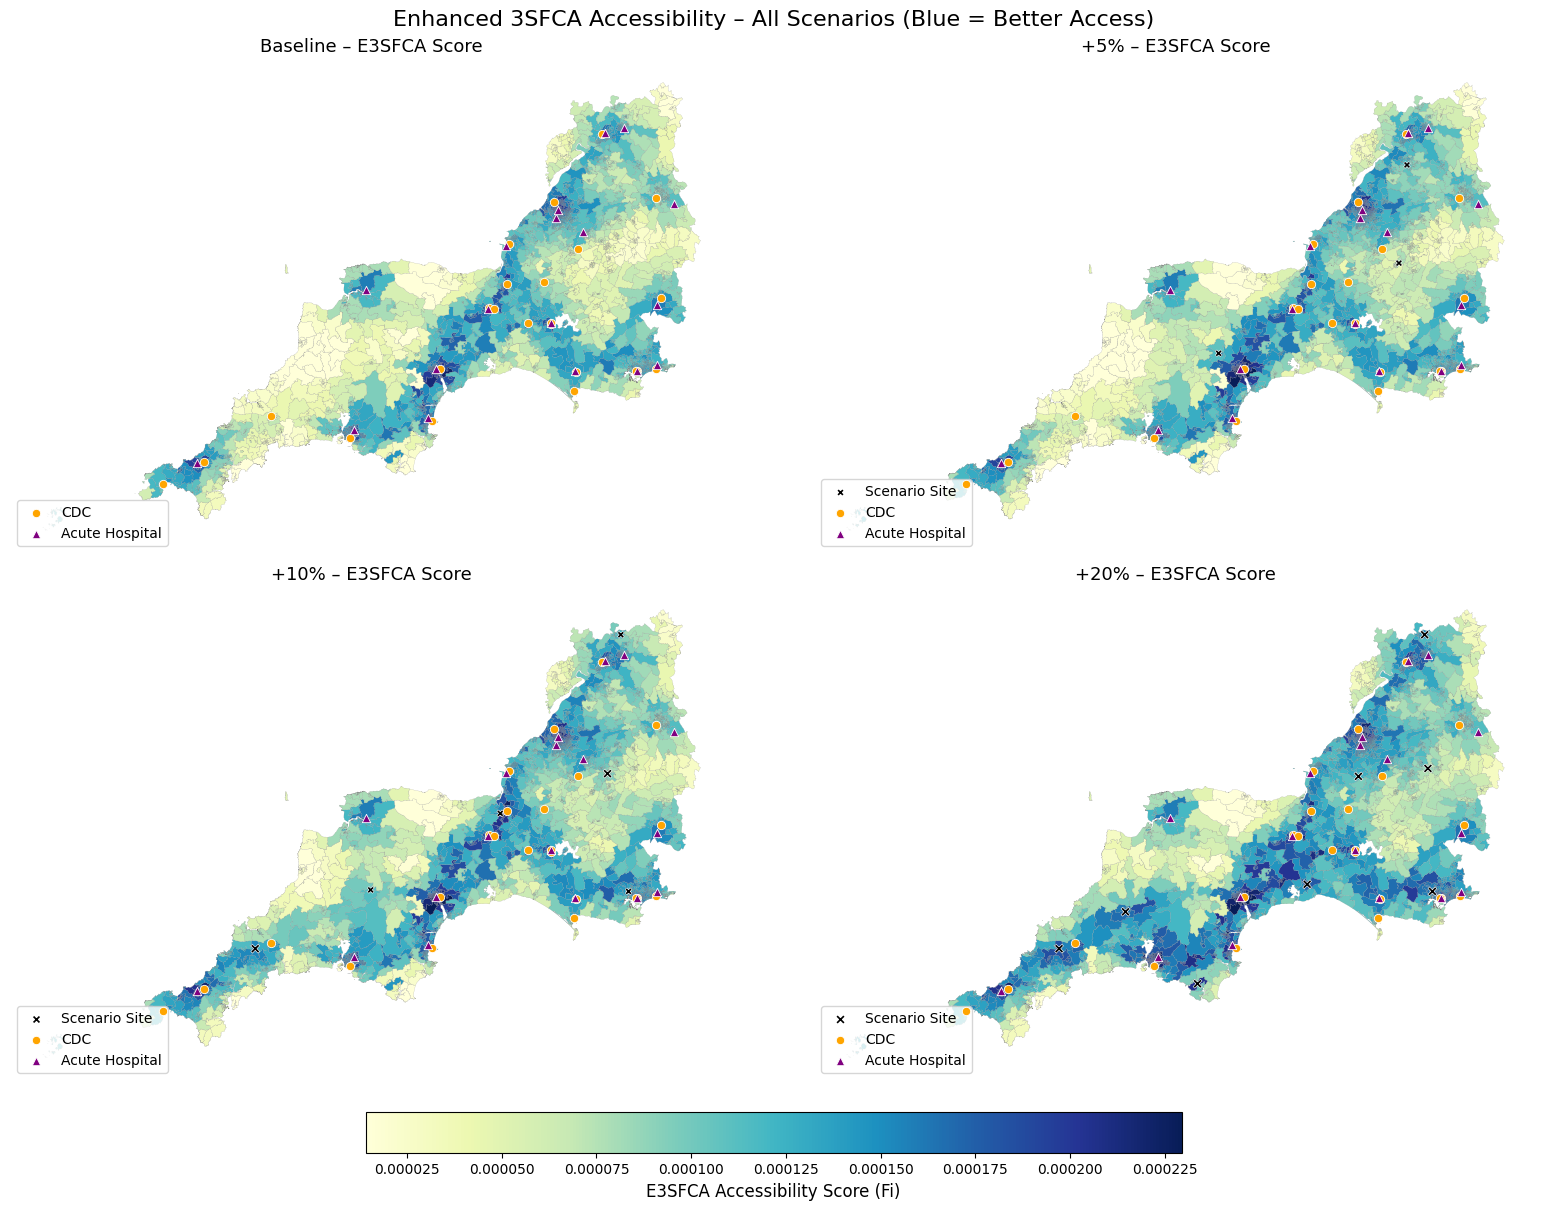

In [46]:
# ----------------------------------------------------------
# Step 8 – 2×2 Choropleth (Blue = Good, Green = Bad) + Facility & Scenario Overlays
# (Solution A: CDC/Acute CSVs already have `lsoa21cd`)
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Figure setup
fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Scenario -> Fi column (from Step 7/7a)
scenarios_plot = {
    "Baseline": "score_baseline",
    "+5%":      "score_plus5pct",
    "+10%":     "score_plus10pct",
    "+20%":     "score_plus20pct",
}

# --- Global colour scale across all panels (robust to outliers)
present_cols = [c for c in scenarios_plot.values() if c in gdf_lsoa.columns]
if present_cols:
    q1  = min(gdf_lsoa[c].quantile(0.01) for c in present_cols)
    q99 = max(gdf_lsoa[c].quantile(0.99) for c in present_cols)
    vmin = float(max(0.0, q1))
    vmax = float(q99)
else:
    vmin, vmax = 0.0, 0.0002  # fallback if scores not present

cmap = "YlGnBu"  # Blue = better access

# Marker scaling
size_scale  = 12   # crosses
facility_ms = 36   # CDC/Acute markers

# ----------------------------------------------------------
# Facilities (Solution A): CSVs already include `lsoa21cd`
# -> join to LSOA polygons for geometry, then centroid to plot as points
# ----------------------------------------------------------
cdc_gdf, acute_gdf = None, None

if 'cdc_path' in globals() and os.path.exists(cdc_path):
    cdc_df = pd.read_csv(cdc_path)
    if "lsoa21cd" in cdc_df.columns:
        cdc_df["lsoa21cd"] = cdc_df["lsoa21cd"].astype(str).str.strip()
        cdc_df = cdc_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(cdc_df, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if 'acute_path' in globals() and os.path.exists(acute_path):
    acute_df = pd.read_csv(acute_path)
    if "lsoa21cd" in acute_df.columns:
        acute_df["lsoa21cd"] = acute_df["lsoa21cd"].astype(str).str.strip()
        acute_df = acute_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(acute_df, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# --- Baseline LSOAs to exclude from crosses (Baseline scenario + facilities)
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# --- Plot loop
for ax, (label, score_col) in zip(axes.flat, scenarios_plot.items()):
    # Choropleth
    if score_col in gdf_lsoa.columns:
        gdf_lsoa.plot(
            column=score_col, cmap=cmap,
            linewidth=0.1, edgecolor="grey",
            legend=False, ax=ax,
            vmin=vmin, vmax=vmax,
            missing_kwds={"color": "lightgrey"},
        )
    else:
        gdf_lsoa.plot(color="lightgrey", linewidth=0.1, edgecolor="grey", ax=ax)

    # Scenario crosses (NEW-only vs baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            # hide crosses where baseline facilities already exist (CDC/Acute/Baseline scenario)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf.geometry.centroid
                # size by scanner_count if available
                if "scanner_count" in site_gdf.columns:
                    sizes = pd.to_numeric(site_gdf["scanner_count"], errors="coerce").fillna(1).astype(float) * size_scale
                else:
                    sizes = pd.Series(1.0, index=site_gdf.index) * size_scale
                # white halo
                site_gdf.plot(ax=ax, marker="x", color="white",
                              markersize=sizes * 1.25, linewidth=2.0, alpha=1.0, zorder=4)
                # black cross
                site_gdf.plot(ax=ax, marker="x", color="black",
                              markersize=sizes, linewidth=1.2, alpha=1.0,
                              label="Scenario Site", zorder=5)

    # Facilities LAST so they appear on top
    if isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(ax=ax, color="orange", marker="o", markersize=facility_ms,
                     edgecolor="white", linewidth=0.6, label="CDC", zorder=6)
    if isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=facility_ms,
                       edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7)

    ax.set_title(f"{label} – E3SFCA Score", fontsize=13)
    ax.axis("off")

    # Clean legend per subplot (dedupe)
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# Shared horizontal colourbar (consistent scale across panels)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal',
                    fraction=0.04, pad=0.03)
cbar.set_label("E3SFCA Accessibility Score (Fi)", fontsize=12)

fig.suptitle("Enhanced 3SFCA Accessibility – All Scenarios (Blue = Better Access)", fontsize=16)
fig.savefig("E3SFCA_scenarios_crosses_300dpi.png", dpi=300, bbox_inches="tight")
plt.show()


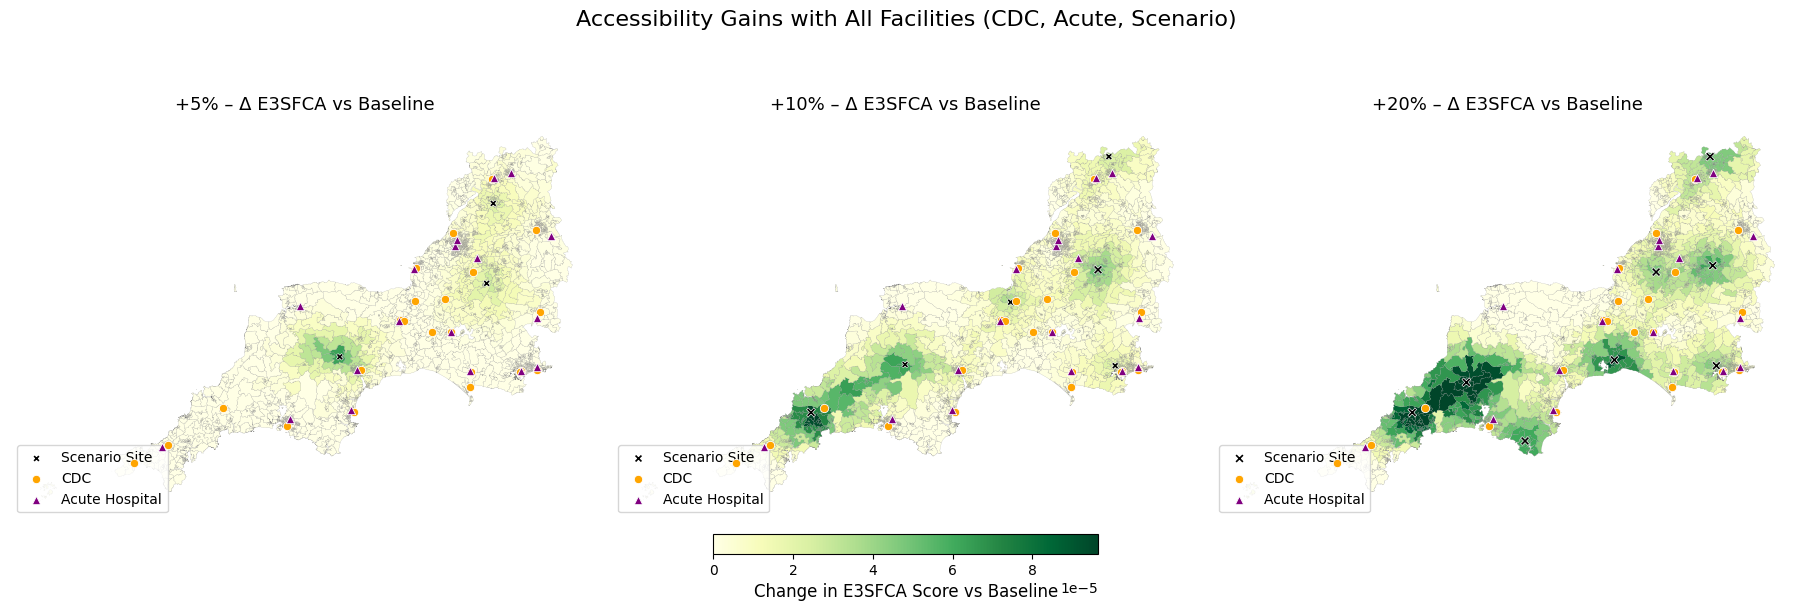

In [47]:
# ----------------------------------------------------------
# Step 8b – Delta Maps (vs Baseline) + CDC (orange), Acute (purple), Scenario Crosses
# (Solution A: CDC/Acute CSVs already have `lsoa21cd`)
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Define delta column mapping for each scenario vs baseline
delta_plot = {
    "+5%":  "delta_plus5pct",
    "+10%": "delta_plus10pct",
    "+20%": "delta_plus20pct",
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Robust scale across available delta columns (clip 1–99th pct)
delta_cols_available = [c for c in delta_plot.values() if c in gdf_lsoa.columns]
if delta_cols_available:
    vmin_delta = float(min(gdf_lsoa[c].quantile(0.01) for c in delta_cols_available))
    vmax_delta = float(max(gdf_lsoa[c].quantile(0.99) for c in delta_cols_available))
else:
    vmin_delta, vmax_delta = 0.0, 0.0  # fallback if no delta columns present

# Marker scaling
size_scale  = 12   # crosses
facility_ms = 36   # CDC/Acute marker size

# ----------------------------------------------------------
# Facilities (Solution A): build cdc_gdf / acute_gdf if not already present
# -> join to LSOA polygons for geometry; centroid to plot as points
# ----------------------------------------------------------
if ('cdc_gdf' not in globals() or not isinstance(cdc_gdf, gpd.GeoDataFrame) or cdc_gdf.empty) and 'cdc_path' in globals() and os.path.exists(cdc_path):
    _cdc_df = pd.read_csv(cdc_path)
    if "lsoa21cd" in _cdc_df.columns:
        _cdc_df["lsoa21cd"] = _cdc_df["lsoa21cd"].astype(str).str.strip()
        _cdc_df = _cdc_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_cdc_df, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if ('acute_gdf' not in globals() or not isinstance(acute_gdf, gpd.GeoDataFrame) or acute_gdf.empty) and 'acute_path' in globals() and os.path.exists(acute_path):
    _acute_df = pd.read_csv(acute_path)
    if "lsoa21cd" in _acute_df.columns:
        _acute_df["lsoa21cd"] = _acute_df["lsoa21cd"].astype(str).str.strip()
        _acute_df = _acute_df.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_acute_df, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# Baseline LSOAs to exclude from crosses (Baseline scenario + facilities)
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# Plot panels
for ax, (label, delta_col) in zip(axes.flat, delta_plot.items()):
    # Choropleth (Green = accessibility gain)
    if delta_col in gdf_lsoa.columns:
        gdf_lsoa.plot(
            column=delta_col,
            cmap="YlGn",
            linewidth=0.1,
            edgecolor="grey",
            legend=False,
            ax=ax,
            vmin=vmin_delta,
            vmax=vmax_delta,
            missing_kwds={"color": "lightgrey"}
        )
    else:
        gdf_lsoa.plot(color="lightgrey", linewidth=0.1, edgecolor="grey", ax=ax)

    # Scenario sites as black crosses with white halo (exclude baseline CDC/Acute/Baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd", "geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf["geometry"].centroid
                # Size by scanner_count if available
                if "scanner_count" in site_gdf.columns:
                    sizes = pd.to_numeric(site_gdf["scanner_count"], errors="coerce").fillna(1).astype(float) * size_scale
                else:
                    sizes = pd.Series(1.0, index=site_gdf.index) * size_scale

                # White halo (underlay)
                site_gdf.plot(
                    ax=ax, marker="x", color="white",
                    markersize=sizes * 1.25, linewidth=2.0, alpha=1.0, zorder=4
                )
                # Black cross (overlay)
                site_gdf.plot(
                    ax=ax, marker="x", color="black",
                    markersize=sizes, linewidth=1.2, alpha=1.0,
                    label="Scenario Site", zorder=5
                )

    # Facilities LAST so they appear on top
    if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(
            ax=ax, color="orange", marker="o", markersize=facility_ms,
            edgecolor="white", linewidth=0.6, label="CDC", zorder=6
        )
    if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(
            ax=ax, color="purple", marker="^", markersize=facility_ms,
            edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7
        )

    ax.set_title(f"{label} – Δ E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")
    # Legend (dedupe)
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# Shared horizontal colourbar
sm = mpl.cm.ScalarMappable(cmap="YlGn", norm=mpl.colors.Normalize(vmin=vmin_delta, vmax=vmax_delta))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("Change in E3SFCA Score vs Baseline", fontsize=12)

plt.suptitle("Accessibility Gains with All Facilities (CDC, Acute, Scenario)", fontsize=16)

# Save at 300 DPI
fig.savefig("E3SFCA_delta_maps_300dpi.png", dpi=300, bbox_inches="tight")
plt.show()


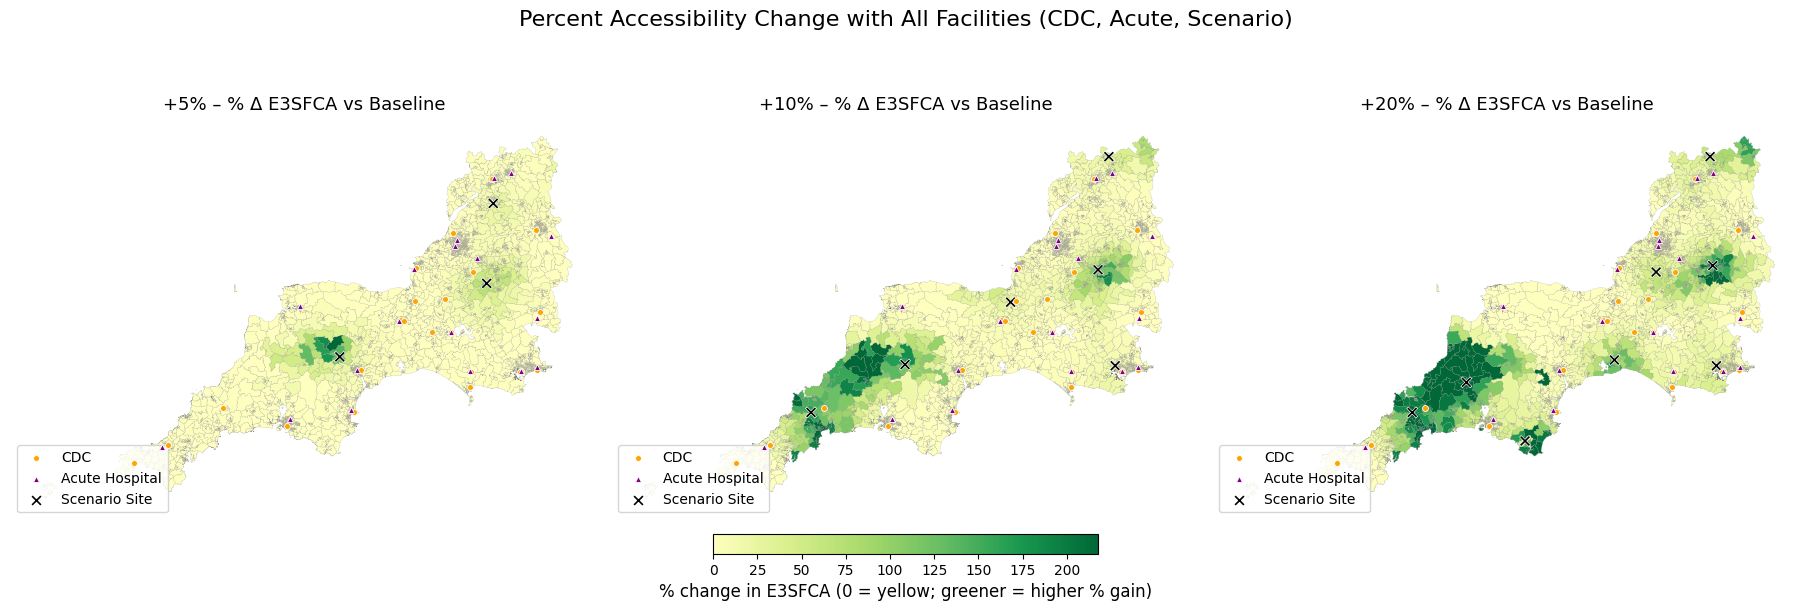

In [49]:
# ----------------------------------------------------------
# Step 8b – % Change Maps (vs Baseline) + CDC (orange), Acute (purple), Scenario Crosses
# (Solution A: CDC/Acute CSVs already include `lsoa21cd`)
# Icons 50% smaller; colourbar shows only +% with 0 as yellow
# ----------------------------------------------------------
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# --- Scenarios to compare vs baseline (scores were merged in Step 7a)
scenarios_plot = {
    "+5%":  "score_plus5pct",
    "+10%": "score_plus10pct",
    "+20%": "score_plus20pct",
}

# --- Pick the baseline column robustly
baseline_candidates = [
    "score_baseline",
    "enhanced_3sfca_score_baseline",
    "enhanced_3sfca_score",
    "Fi", "fi", "E3SFCA",
]
baseline_col = next((c for c in baseline_candidates if c in gdf_lsoa.columns), None)
if baseline_col is None:
    raise KeyError("No baseline score column found in gdf_lsoa.")

# --- Ensure CDC/Acute GeoDataFrames exist (Solution A: CSVs contain `lsoa21cd`)
if ('cdc_gdf' not in globals() or not isinstance(cdc_gdf, gpd.GeoDataFrame) or cdc_gdf.empty) \
   and 'cdc_path' in globals() and os.path.exists(cdc_path):
    _cdc = pd.read_csv(cdc_path)
    if "lsoa21cd" in _cdc.columns:
        _cdc["lsoa21cd"] = _cdc["lsoa21cd"].astype(str).str.strip()
        _cdc = _cdc.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        cdc_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_cdc, on="lsoa21cd", how="right")
        cdc_gdf = gpd.GeoDataFrame(cdc_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        cdc_gdf = cdc_gdf.set_geometry(cdc_gdf.geometry.centroid)

if ('acute_gdf' not in globals() or not isinstance(acute_gdf, gpd.GeoDataFrame) or acute_gdf.empty) \
   and 'acute_path' in globals() and os.path.exists(acute_path):
    _acute = pd.read_csv(acute_path)
    if "lsoa21cd" in _acute.columns:
        _acute["lsoa21cd"] = _acute["lsoa21cd"].astype(str).str.strip()
        _acute = _acute.dropna(subset=["lsoa21cd"]).drop_duplicates("lsoa21cd")
        acute_gdf = gdf_lsoa[["lsoa21cd", "geometry"]].merge(_acute, on="lsoa21cd", how="right")
        acute_gdf = gpd.GeoDataFrame(acute_gdf, geometry="geometry", crs=gdf_lsoa.crs)
        acute_gdf = acute_gdf.set_geometry(acute_gdf.geometry.centroid)

# --- % change per LSOA for each scenario vs baseline
pct_cols = {}
base = pd.to_numeric(gdf_lsoa[baseline_col], errors="coerce").astype(float)
for label, scen_col in scenarios_plot.items():
    if scen_col not in gdf_lsoa.columns:
        continue
    scen = pd.to_numeric(gdf_lsoa[scen_col], errors="coerce").astype(float)
    pct_col = f"pct_{label.lower().replace('+','plus').replace('%','pct')}"
    # Avoid div-by-zero: NaN where baseline is 0 or NaN
    gdf_lsoa[pct_col] = np.where(base > 0, (scen - base) / base * 100.0, np.nan)
    pct_cols[label] = pct_col

# --- Diverging norm for the maps (RdYlGn centered at 0)
vals = np.concatenate([gdf_lsoa[c].to_numpy(dtype=float) for c in pct_cols.values()]) if pct_cols else np.array([0.0])
vals = vals[np.isfinite(vals)]
if vals.size == 0:
    vals = np.array([0.0])
low, high = np.percentile(vals, 1), np.percentile(vals, 99)
vabs = float(max(abs(low), abs(high), 1e-6))  # guard tiny ranges
map_norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)

# --- Positive-only colourbar (0..+vabs), with 0 at yellow (upper half of RdYlGn)
_rdylgn = mpl.cm.get_cmap("RdYlGn")
pos_cmap = LinearSegmentedColormap.from_list("RdYlGn_pos", _rdylgn(np.linspace(0.5, 1.0, 256)))
pos_norm = mpl.colors.Normalize(vmin=0.0, vmax=vabs)

# --- Figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# --- Icon sizes (50% smaller than earlier)
size_scale = 12  # default scale for crosses if not defined before
size_scale = size_scale * 0.5
facility_ms = 36 * 0.5  # CDC/Acute markers
clip_min, clip_max = 40, 225  # for cross marker sizes

# --- Baseline LSOAs to suppress scenario crosses (Baseline sites + CDC + Acute)
baseline_lsoa = set()
if 'scenario_site_data' in globals() and "Baseline" in scenario_site_data:
    baseline_lsoa |= set(scenario_site_data["Baseline"]["lsoa21cd"].astype(str))
if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty and "lsoa21cd" in cdc_gdf.columns:
    baseline_lsoa |= set(cdc_gdf["lsoa21cd"].astype(str))
if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty and "lsoa21cd" in acute_gdf.columns:
    baseline_lsoa |= set(acute_gdf["lsoa21cd"].astype(str))

# --- Plot panels
for ax, (label, pct_col) in zip(axes.flat, pct_cols.items()):
    # Choropleth (% change, diverging, centered at 0)
    gdf_lsoa.plot(
        column=pct_col, cmap="RdYlGn", norm=map_norm,
        linewidth=0.1, edgecolor="grey", legend=False, ax=ax,
        missing_kwds={"color": "lightgrey"}
    )

    # Baseline facilities (smaller icons)
    if 'cdc_gdf' in globals() and isinstance(cdc_gdf, gpd.GeoDataFrame) and not cdc_gdf.empty:
        cdc_gdf.plot(ax=ax, color="orange", marker="o", markersize=facility_ms,
                     edgecolor="white", linewidth=0.6, label="CDC", zorder=6)
    if 'acute_gdf' in globals() and isinstance(acute_gdf, gpd.GeoDataFrame) and not acute_gdf.empty:
        acute_gdf.plot(ax=ax, color="purple", marker="^", markersize=facility_ms,
                       edgecolor="white", linewidth=0.6, label="Acute Hospital", zorder=7)

    # Scenario sites as black crosses with white halo (exclude baseline LSOAs)
    if 'scenario_site_data' in globals() and label in scenario_site_data:
        site_df = scenario_site_data[label].copy()
        if not site_df.empty:
            site_df["lsoa21cd"] = site_df["lsoa21cd"].astype(str)
            if baseline_lsoa:
                site_df = site_df[~site_df["lsoa21cd"].isin(baseline_lsoa)]
            if not site_df.empty:
                site_df = site_df.merge(gdf_lsoa[["lsoa21cd","geometry"]], on="lsoa21cd", how="left")
                site_gdf = gpd.GeoDataFrame(site_df, geometry="geometry", crs=gdf_lsoa.crs)
                site_gdf["geometry"] = site_gdf.geometry.centroid
                ms_sites = (
                    pd.to_numeric(site_gdf.get("scanner_count", 1), errors="coerce").fillna(1).astype(float)
                    * size_scale
                ).clip(clip_min, clip_max)

                # White halo (underlay)
                site_gdf.plot(ax=ax, marker="x", color="white",
                              markersize=ms_sites * 1.25, linewidth=2.0, alpha=1.0, zorder=4)
                # Black cross (overlay)
                site_gdf.plot(ax=ax, marker="x", color="black",
                              markersize=ms_sites, linewidth=1.2, alpha=1.0,
                              label="Scenario Site", zorder=5)

    ax.set_title(f"{label} – % Δ E3SFCA vs Baseline", fontsize=13)
    ax.axis("off")
    # Dedupe legend per subplot
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        uniq = dict(zip(labels_, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="lower left", frameon=True)

# --- Positive-only colourbar (0..+vabs), with 0 as yellow
sm_pos = mpl.cm.ScalarMappable(cmap=pos_cmap, norm=pos_norm)
sm_pos._A = []
cbar = fig.colorbar(sm_pos, ax=axes.ravel().tolist(),
                    orientation='horizontal', fraction=0.04, pad=0.03)
cbar.set_label("% change in E3SFCA (0 = yellow; greener = higher % gain)", fontsize=12)

plt.suptitle("Percent Accessibility Change with All Facilities (CDC, Acute, Scenario)", fontsize=16)

# --- Save @300 DPI
out_path = "Step8b_percent_change_maps_300dpi.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


In [51]:
# --- Quick summary: how many LSOAs improved/worsened/unchanged (by scenario) ---

import numpy as np
import pandas as pd

# Preferred scenario order
_scenarios = ["+5%", "+10%", "+20%"]

# 1) Choose columns: prefer % change, else delta
pct_candidates   = {"+5%":"pct_plus5pct", "+10%":"pct_plus10pct", "+20%":"pct_plus20pct"}
delta_candidates = {s: f"delta_{s.lower().replace('+','plus').replace('%','pct')}" for s in _scenarios}

pct_available   = {k:v for k,v in pct_candidates.items()   if v in gdf_lsoa.columns}
delta_available = {k:v for k,v in delta_candidates.items() if v in gdf_lsoa.columns}

if pct_available:
    change_cols = pct_available
    units = "%"
    tol   = globals().get("change_tol_pct", 0.001)  # treat |Δ|<=0.001% as unchanged
    print(f"Using % change columns: {change_cols}")
elif delta_available:
    change_cols = delta_available
    units = "ΔFi"
    tol   = globals().get("change_tol_abs", 1e-12)  # near-zero in absolute units
    print(f"Using delta columns: {change_cols}")
else:
    raise KeyError("No percent-change (pct_*) or delta (delta_*) columns found in gdf_lsoa.")

# 2) Build summary per scenario
rows = []
for label in _scenarios:
    if label not in change_cols: 
        continue
    col = change_cols[label]
    s = pd.to_numeric(gdf_lsoa[col], errors="coerce")
    n_total = int(len(s))
    n = int(s.notna().sum())
    n_na = n_total - n

    improved  = int((s >  tol).sum())
    worsened  = int((s < -tol).sum())
    unchanged = int((s.abs() <= tol).sum())

    rows.append({
        "Scenario": label,
        "LSOAs (total)": n_total,
        "LSOAs (valid)": n,
        "NA (n)": n_na,
        "NA (%)": (n_na / n_total * 100) if n_total else np.nan,
        "Improved (n)": improved,
        "Improved (%)": (improved / n * 100) if n else np.nan,
        "Worsened (n)": worsened,
        "Worsened (%)": (worsened / n * 100) if n else np.nan,
        "Unchanged (n)": unchanged,
        "Unchanged (%)": (unchanged / n * 100) if n else np.nan,
        "Net (Improved − Worsened)": improved - worsened,
        "Mean change": s.mean(),
        "Median change": s.median(),
        "P10": s.quantile(0.10),
        "P90": s.quantile(0.90),
        "Min": s.min(),
        "Max": s.max(),
        "Units": units,
        "Tolerance used": tol,
        "Column": col,
    })

df_change_summary = pd.DataFrame(rows)

# 3) Tidy formatting
pct_cols = ["NA (%)", "Improved (%)", "Worsened (%)", "Unchanged (%)"]
for c in pct_cols:
    if c in df_change_summary.columns:
        df_change_summary[c] = df_change_summary[c].round(2)

stat_cols = ["Mean change", "Median change", "P10", "P90", "Min", "Max"]
if units == "%":
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(2)
else:
    df_change_summary[stat_cols] = df_change_summary[stat_cols].round(6)

# 4) Display
try:
    from IPython.display import display
    display(df_change_summary)
except Exception:
    print(df_change_summary.to_string(index=False))


Using % change columns: {'+5%': 'pct_plus5pct', '+10%': 'pct_plus10pct', '+20%': 'pct_plus20pct'}


,Scenario,LSOAs (total),LSOAs (valid),NA (n),NA (%),Improved (n),Improved (%),Worsened (n),Worsened (%),Unchanged (n),...,Net (Improved − Worsened),Mean change,Median change,P10,P90,Min,Max,Units,Tolerance used,Column
0,+5%,3451,3451,0,0.0,2028,58.77,0,0.0,1423,...,2028,5.69,1.77,0.00,15.85,0.0,349.77,%,0.001,pct_plus5pct
1,+10%,3451,3451,0,0.0,3112,90.18,0,0.0,339,...,3112,18.49,6.34,0.78,40.54,0.0,575.03,%,0.001,pct_plus10pct
2,+20%,3451,3451,0,0.0,3262,94.52,0,0.0,189,...,3262,35.06,15.25,3.41,74.24,0.0,2400.96,%,0.001,pct_plus20pct


In [52]:
# ----------------------------------------------------------
# Step 9 – Summary Statistics for E3SFCA Scores and Δ Improvements
# (robust to missing columns; includes Baseline in score summaries)
# ----------------------------------------------------------
import pandas as pd
import numpy as np

# --- 0) Helper: tidy describe into a row dict
def _summ_row(name, s: pd.Series):
    s = pd.to_numeric(s, errors="coerce")
    desc = s.describe(percentiles=[0.25, 0.5, 0.75])
    return {
        "Scenario": name,
        "Count (valid)": int(desc.get("count", 0)),
        "NA (n)": int(s.isna().sum()),
        "Mean": float(desc.get("mean", np.nan)),
        "Median": float(desc.get("50%", np.nan)),
        "Min": float(desc.get("min", np.nan)),
        "Q1": float(desc.get("25%", np.nan)),
        "Q3": float(desc.get("75%", np.nan)),
        "Max": float(desc.get("max", np.nan)),
        "Std Dev": float(desc.get("std", np.nan)),
    }

# --- 1) Find baseline score column
baseline_candidates = [
    "score_baseline",
    "enhanced_3sfca_score_baseline",
    "enhanced_3sfca_score",
    "Fi", "fi", "E3SFCA",
]
baseline_cols_found = [c for c in baseline_candidates if c in gdf_lsoa.columns]
if not baseline_cols_found:
    raise KeyError(f"No baseline score column found. Have: {list(gdf_lsoa.columns)}")
baseline_col = baseline_cols_found[0]

# --- 2) Build scenario→column map safely (only keep existing columns)
default_scenarios_plot = {
    "Baseline": "score_baseline",
    "+5%":      "score_plus5pct",
    "+10%":     "score_plus10pct",
    "+20%":     "score_plus20pct",
}
scenarios_plot_use = {k: v for k, v in default_scenarios_plot.items() if v in gdf_lsoa.columns}

# --- 3) Absolute score summaries (print baseline + each scenario present)
print("\n--- E3SFCA Score Summary ---")
print("\nBaseline")
print(pd.to_numeric(gdf_lsoa[baseline_col], errors="coerce").describe(percentiles=[0.25, 0.5, 0.75]).round(6))

for label, col in scenarios_plot_use.items():
    if label == "Baseline":  # already printed above
        continue
    print(f"\n{label}")
    print(pd.to_numeric(gdf_lsoa[col], errors="coerce").describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- 4) Δ score summaries (vs baseline) if available or constructable
# Prefer an existing delta_plot (from Step 8b), else construct expected names and keep those present
if 'delta_plot' in globals() and isinstance(delta_plot, dict):
    delta_plot_use = {k: v for k, v in delta_plot.items() if v in gdf_lsoa.columns}
else:
    candidate_deltas = {s: f"delta_{s.lower().replace('+','plus').replace('%','pct')}" for s in ["+5%", "+10%", "+20%"]}
    delta_plot_use = {k: v for k, v in candidate_deltas.items() if v in gdf_lsoa.columns}

if delta_plot_use:
    print("\n--- Δ E3SFCA vs Baseline Summary ---")
    for label, delta_col in delta_plot_use.items():
        print(f"\n{label}")
        print(pd.to_numeric(gdf_lsoa[delta_col], errors="coerce").describe(percentiles=[0.25, 0.5, 0.75]).round(6))

# --- 5) Summary table for absolute scores (with Baseline row)
rows_scores = []
rows_scores.append(_summ_row("Baseline", gdf_lsoa[baseline_col]))

for label, col in scenarios_plot_use.items():
    if label == "Baseline":
        continue
    rows_scores.append(_summ_row(label, gdf_lsoa[col]))

df_scores_summary = pd.DataFrame(rows_scores).round(6)

# --- 6) Summary table for deltas (if present; baseline not applicable)
df_deltas_summary = None
if delta_plot_use:
    rows_deltas = []
    for label, col in delta_plot_use.items():
        rows_deltas.append(_summ_row(label, gdf_lsoa[col]))
    df_deltas_summary = pd.DataFrame(rows_deltas).round(6)

# --- 7) (Optional) Percent-change summaries if pct_* columns exist
pct_map = {s: f"pct_{s.lower().replace('+','plus').replace('%','pct')}" for s in ["+5%", "+10%", "+20%"]}
pct_map_use = {k: v for k, v in pct_map.items() if v in gdf_lsoa.columns}
df_pct_summary = None
if pct_map_use:
    rows_pct = []
    for label, col in pct_map_use.items():
        rows_pct.append(_summ_row(label, gdf_lsoa[col]))
    df_pct_summary = pd.DataFrame(rows_pct).round(2)  # % values—2dp is fine

# --- 8) Display nicely
try:
    from IPython.display import display
    print("\n\n=== Table: E3SFCA Scores (Absolute) ===")
    display(df_scores_summary)
    if df_deltas_summary is not None:
        print("\n=== Table: Δ E3SFCA vs Baseline ===")
        display(df_deltas_summary)
    if df_pct_summary is not None:
        print("\n=== Table: % Change vs Baseline ===")
        display(df_pct_summary)
except Exception:
    print("\n\n=== Table: E3SFCA Scores (Absolute) ===")
    print(df_scores_summary.to_string(index=False))
    if df_deltas_summary is not None:
        print("\n=== Table: Δ E3SFCA vs Baseline ===")
        print(df_deltas_summary.to_string(index=False))
    if df_pct_summary is not None:
        print("\n=== Table: % Change vs Baseline ===")
        print(df_pct_summary.to_string(index=False))



--- E3SFCA Score Summary ---

Baseline
count    3451.000000
mean        0.000114
std         0.000046
min         0.000001
25%         0.000081
50%         0.000118
75%         0.000148
max         0.000260
Name: score_baseline, dtype: float64

+5%
count    3451.000000
mean        0.000118
std         0.000047
min         0.000001
25%         0.000087
50%         0.000122
75%         0.000151
max         0.000264
Name: score_plus5pct, dtype: float64

+10%
count    3451.000000
mean        0.000126
std         0.000044
min         0.000001
25%         0.000095
50%         0.000129
75%         0.000159
max         0.000264
Name: score_plus10pct, dtype: float64

+20%
count    3451.000000
mean        0.000137
std         0.000046
min         0.000001
25%         0.000105
50%         0.000143
75%         0.000172
max         0.000273
Name: score_plus20pct, dtype: float64

--- Δ E3SFCA vs Baseline Summary ---

+5%
count    3451.000000
mean        0.000005
std         0.000007
min         0.0

,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,Baseline,3451,0,0.000114,0.000118,0.000001,0.000081,0.000148,0.000260,0.000046
1,+5%,3451,0,0.000118,0.000122,0.000001,0.000087,0.000151,0.000264,0.000047
2,+10%,3451,0,0.000126,0.000129,0.000001,0.000095,0.000159,0.000264,0.000044
3,+20%,3451,0,0.000137,0.000143,0.000001,0.000105,0.000172,0.000273,0.000046



=== Table: Δ E3SFCA vs Baseline ===


,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,+5%,3451,0,0.000005,0.000002,0.0,0.000000,0.000007,0.000063,0.000007
1,+10%,3451,0,0.000012,0.000008,0.0,0.000003,0.000015,0.000096,0.000013
2,+20%,3451,0,0.000024,0.000018,0.0,0.000009,0.000032,0.000134,0.000020



=== Table: % Change vs Baseline ===


,Scenario,Count (valid),NA (n),Mean,Median,Min,Q1,Q3,Max,Std Dev
0,+5%,3451,0,5.69,1.77,0.0,0.00,5.34,349.77,13.71
1,+10%,3451,0,18.49,6.34,0.0,2.61,13.62,575.03,39.49
2,+20%,3451,0,35.06,15.25,0.0,7.74,29.28,2400.96,83.48
